In [1]:
pip install zemberek-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 7.0 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141214 sha256=bf2c3facdd3d71bdcd822dfefcaf1ec2eee25ffec4c83d6ac5dad8ba72db8f7f
  Stored in directory: /root/.cache/pip/wheels/21/10/be/9a70640a3a60ed4a7e1a45e49bb9f58b04692d5d7b517bd39e
Successfully built antlr4-python3-runtime


In [2]:
from google.colab import drive
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from zemberek import TurkishMorphology
from zemberek.normalization import TurkishSpellChecker
from zemberek.tokenization import TurkishTokenizer

In [4]:
# Google Drive'ı bağlama
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Downloading the NLTK stopwords dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Loading Zemberek components
morphology = TurkishMorphology.create_with_defaults()
spell_checker = TurkishSpellChecker(morphology)
tokenizer = TurkishTokenizer.DEFAULT
stop_words = set(stopwords.words('turkish'))


INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 8.490204572677612


2025-03-07 13:48:09,923 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 8.490204572677612



In [15]:
#data
final_combined_data = pd.read_csv('birlesik_veri_seti.csv')

In [16]:
# Preparing the dataset with only Row ID, Tweet, and Label columns
filtered_data = final_combined_data[['row ID', 'Tweet', 'Etiket']].copy()

# Adding row names
filtered_data['row ID'] = ['row ' + str(i) for i in range(len(filtered_data))]

Class Distribution:
Etiket
hiçbiri      8386
nefret       2612
saldırgan     226
Name: count, dtype: int64


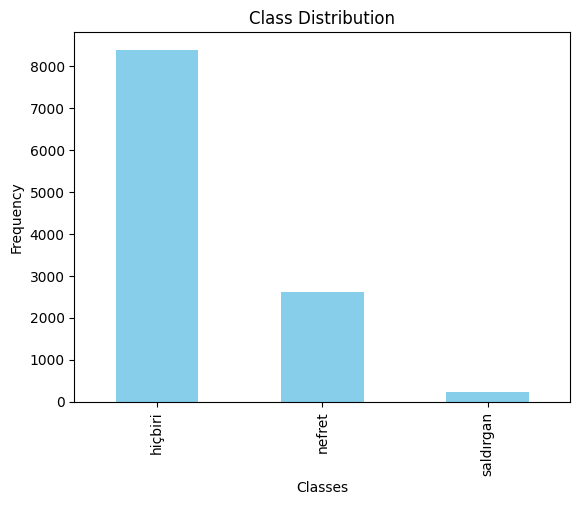

In [17]:
# Class Distribution Analysis
print("Class Distribution:")
class_distribution = filtered_data['Etiket'].value_counts()
print(class_distribution)

# Visualizing Class Distribution
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from zemberek import TurkishMorphology
from functools import lru_cache
import time
import re
from zemberek import TurkishMorphology, TurkishSentenceNormalizer


normalizer = TurkishSentenceNormalizer(morphology)
# Zemberek Morphology başlatılıyor
morphology = TurkishMorphology.create_with_defaults()

# Kontrol sayacı
check_counter = 0

@lru_cache(maxsize=50000)
def cached_spell_check(word):
    global check_counter
    check_counter += 1
    if check_counter % 1000 == 0:
        print(f"{check_counter} kelime kontrol edildi...")

    # Yazım kontrolü ve öneri alma
    suggestions = spell_checker.suggest_for_word(word)
    corrected_word = suggestions[0] if suggestions else word

    # Lemmatization işlemi
    analysis = morphology.analyze(corrected_word)
    lemmas = [result.get_stem() for result in analysis]

    # Eğer lemma bulunmuşsa ilkini döndür, yoksa düzeltilmiş kelimeyi döndür
    return lemmas[0] if lemmas else corrected_word

# Tokenizasyon ve stopword temizleme
def tokenize_and_clean(text):
    # Küçük harfe çevirme
    text = text.lower()

    # URL'leri kaldırma
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Kullanıcı etiketlerini kaldırma (@mention)
    text = re.sub(r'@\w+', '', text)

    # Sayıları kaldırma
    text = re.sub(r'[0-9]', '', text)

    # Noktalama işaretlerini kaldırma
    text = re.sub(r'[^\w\s]', '', text)

    # Fazla boşlukları temizleme
    text = re.sub(r'\s+', ' ', text).strip()

    # Normalizasyon (Loodos mantığına göre Zemberek ile)
    text = normalizer.normalize(text)  # Metni normalize et (örneğin, yanlış yazımları düzelt)

    # Tokenize işlemi (kelimelere ayırma)
    tokens = [token.content for token in tokenizer.tokenize(text)]

    # Stopwords (gereksiz kelimeleri) kaldırma
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


# Yazım düzeltmesi yapılmış token'ları saklamak için fonksiyon
def correct_tokens_separately(tokens):
    corrected_tokens = [cached_spell_check(token) for token in tokens]
    return corrected_tokens  # Burada, her kelimeyi düzeltip geri döndürüyoruz.



# Metin ön işleme adımlarını ayrı ayrı çalıştırma ve süre ölçme
processed_data = filtered_data.copy()

# Tokenizasyon ve stopword temizleme süresi
start_time = time.time()
processed_data['Tokens'] = processed_data['Tweet'].apply(tokenize_and_clean)
end_time = time.time()
print(f"Tokenizasyon ve stopword temizleme süresi: {end_time - start_time:.2f} saniye")

#yazım düzeltme süresi
start_time = time.time()
processed_data['Processed Tokens'] = processed_data['Tokens'].apply(correct_tokens_separately)
end_time = time.time()
print(f"yazım düzeltme süresi: {end_time - start_time:.2f} saniye")

# İşlenmiş veri setini kontrol etme
print("İşlenmiş veri setinin ilk 5 satırı:")
print(processed_data.head())
print("\nİşlenmiş veri setinin son 5 satırı:")
print(processed_data.tail())



INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 5.976700782775879


2025-01-02 00:15:20,787 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 5.976700782775879

Tokenizasyon ve stopword temizleme süresi: 899.59 saniye
1000 kelime kontrol edildi...
2000 kelime kontrol edildi...
3000 kelime kontrol edildi...
4000 kelime kontrol edildi...
5000 kelime kontrol edildi...
6000 kelime kontrol edildi...
7000 kelime kontrol edildi...
8000 kelime kontrol edildi...
9000 kelime kontrol edildi...
10000 kelime kontrol edildi...
11000 kelime kontrol edildi...
12000 kelime kontrol edildi...
13000 kelime kontrol edildi...
14000 kelime kontrol edildi...
15000 kelime kontrol edildi...
16000 kelime kontrol edildi...
17000 kelime kontrol edildi...
18000 kelime kontrol edildi...
19000 kelime kontrol edildi...
20000 kelime kontrol edildi...
21000 kelime kontrol edildi...
22000 kelime kontrol edildi...
23000 kelime kontrol edildi...
24000 kelime kontrol edildi...
25000 kelime kontrol edildi...
26000 kelime kontrol edildi...
27000 ke

In [18]:
# CSV dosyasını okuma
input_file = '/content/drive/MyDrive/processed_data1.csv'
processed_data = pd.read_csv(input_file)

In [19]:
import logging
import sys
import multiprocessing
import itertools
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
processed_data['Processed Tokens'] = processed_data['Processed Tokens'].apply(lambda x: eval(x) if isinstance(x, str) else x)
print(processed_data['Processed Tokens'].apply(lambda x: 'eşcinsel' in x))

# Model eğitimi
word2_model1 = Word2Vec(sentences=processed_data['Processed Tokens'], vector_size=100, window=5, min_count=1, sg=1, negative=4, epochs=10, workers=multiprocessing.cpu_count())


In [21]:
word2_model1.save("word2vec_model.model")


INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'word2vec_model.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-07T13:50:56.291446', 'gensim': '4.3.3', 'python': '3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]', 'platform': 'Linux-6.1.85+-x86_64-with-glibc2.35', 'event': 'saving'}


2025-03-07 13:50:56,291 - gensim.utils - INFO
Msg: Word2Vec lifecycle event {'fname_or_handle': 'word2vec_model.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-03-07T13:50:56.291446', 'gensim': '4.3.3', 'python': '3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]', 'platform': 'Linux-6.1.85+-x86_64-with-glibc2.35', 'event': 'saving'}



INFO:gensim.utils:not storing attribute cum_table


2025-03-07 13:50:56,293 - gensim.utils - INFO
Msg: not storing attribute cum_table



INFO:gensim.utils:saved word2vec_model.model


2025-03-07 13:50:56,338 - gensim.utils - INFO
Msg: saved word2vec_model.model



In [22]:
import numpy as np

def get_sentence_vector(model, tokens):
    # Tokenler modelde varsa, kelime vektörlerini alıp ortalamasını döndürüyoruz
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [23]:
# Cümle vektörlerini elde ediyoruz
processed_data['Word Vector'] = processed_data['Processed Tokens'].apply(lambda x: get_sentence_vector(word2_model1, x))
from sklearn.preprocessing import LabelEncoder

# Etiket sütununu sayısal verilere dönüştürme
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(processed_data['Etiket'])

# Bu aşamada, eğer etiketli bir veri kümeniz varsa, etiketleri de alıyoruz
X = np.array(processed_data['Word Vector'].tolist())  # Giriş vektörleri
y = numeric_labels  # Etiketler (sınıflar)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Daha önce oluşturulan kombinasyonlar (count_combination_data, tfidf_combination_data) kullanılacak
# Çıktılar için dosya yolunu ayarlama
output_dir = "/content/drive/MyDrive/outputs1"
os.makedirs(output_dir, exist_ok=True)

# Etiketleri Yükleme ve Sayısal Dönüşüm
labels = processed_data['Etiket']
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
print(f"Etiketler dönüştürüldü: {list(label_encoder.classes_)}")

# Veri Seti Bölme Fonksiyonu

def split_data(matrix, labels):
    # LightGBM ve diğer modeller için gerekli dönüşüm
    matrix = matrix.astype(np.float32) if hasattr(matrix, 'astype') else matrix
    return train_test_split(matrix, labels, test_size=0.16, random_state=42)

# Performans Ölçüm Fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Precision, Recall, F1-Score ve Accuracy hesaplamaları
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, predictions)

    # Metriği ekrana yazdırma
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return precision, recall, f1, accuracy, predictions

# Confusion Matrix Görselleştirme Fonksiyonu
def save_confusion_matrix(y_true, y_pred, model_name, data_type):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {model_name} ({data_type})")
    file_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{data_type}.png")
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    print(f"Confusion matrix kaydedildi: {file_path}")

# Eğitim ve Doğrulama Metriklerini Kaydetme Fonksiyonu
def save_training_validation_metrics(history, model_name, data_type):
    epochs = range(1, len(history['loss']) + 1)

    # Loss Grafiği
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f"Loss - {model_name} ({data_type})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    file_path_loss = os.path.join(output_dir, f"loss_{model_name}_{data_type}.png")
    plt.savefig(file_path_loss, bbox_inches='tight')
    plt.close()
    print(f"Loss grafiği kaydedildi: {file_path_loss}")

    # Accuracy Grafiği
    plt.plot(epochs, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {model_name} ({data_type})")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    file_path_acc = os.path.join(output_dir, f"accuracy_{model_name}_{data_type}.png")
    plt.savefig(file_path_acc, bbox_inches='tight')
    plt.close()
    print(f"Accuracy grafiği kaydedildi: {file_path_acc}")

# Kombinasyonlar için Performans Değerlendirme Tablosu
results = []






Etiketler dönüştürüldü: ['hiçbiri', 'nefret', 'saldırgan']


In [25]:
import matplotlib.pyplot as plt

def evaluate_random_forest_with_word2vec():
    print(f"Word2Vec ile Random Forest modeli değerlendiriliyor...")

    # Cümle vektörlerini alıyoruz
    X = np.array(processed_data['Word Vector'].tolist())
    y = numeric_labels  # Etiketler

    X_train, X_test, y_train, y_test = split_data(X, y)

    n_range = range(1, 2, 1)  # Farklı ağaç sayıları
    accuracies = []
    oob_scores = []

    for n in n_range:
        model = RandomForestClassifier(
            n_estimators=500,
            max_depth=11,
            min_samples_split=4,
            min_samples_leaf=1,
            oob_score=True,  # OOB Score'u hesapla
            random_state=42
        )

        precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)

        accuracies.append(accuracy)
        oob_scores.append(model.oob_score_)

        print(f"Ağaç Sayısı: {n}, Accuracy: {accuracy:.4f}, OOB Score: {model.oob_score_:.4f}")
    # Confusion Matrix Kaydetme
    save_confusion_matrix(y_test, predictions, "RandomForest", 'Word2Vec')
    # Doğruluk ve OOB Skoru Grafiği
    # plt.figure(figsize=(10, 5))
    # plt.plot(n_range, accuracies, marker='o', label='Test Accuracy', color='blue')
    # plt.plot(n_range, oob_scores, marker='s', label='OOB Score', color='red')

    # plt.xlabel("Ağaç Sayısı (n_estimators)")
    # plt.ylabel("Skor")
    # plt.title("Random Forest: Ağaç Sayısına Göre Doğruluk ve OOB Skoru")
    # plt.legend()
    # plt.grid()
    # plt.show()


In [26]:
# Değerlendirme İşlemi
print("Random Forest Modeli Değerlendiriliyor...")
evaluate_random_forest_with_word2vec()

Random Forest Modeli Değerlendiriliyor...
Word2Vec ile Random Forest modeli değerlendiriliyor...
Precision: 0.8103, Recall: 0.8179, F1-Score: 0.7819, Accuracy: 0.8179
Ağaç Sayısı: 1, Accuracy: 0.8179, OOB Score: 0.8037
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1/confusion_matrix_RandomForest_Word2Vec.png


In [27]:
# XGBoost Modeli
def evaluate_xgboost():
  print(f"Word2Vec ile Xgboost modeli değerlendiriliyor...")
 # Cümle vektörlerini alıyoruz
  X = np.array(processed_data['Word Vector'].tolist())
  y = numeric_labels  # Etiketler

  X_train, X_test, y_train, y_test = split_data(X, y)
  n_range = range(100, 200, 100)  # Farklı ağaç sayıları
  accuracies = []
  for n in n_range:
      model = XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            n_estimators=700,
            max_depth=15,
            learning_rate=0.25,
            subsample=0.8
                )
      precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)

      accuracies.append(accuracy)

      print(f"Ağaç Sayısı: {n}, Accuracy: {accuracy:.4f}")


            # Confusion Matrix Kaydetme
  save_confusion_matrix(y_test, predictions, "XGBoost", 'Word2Vec')


In [28]:
# Değerlendirme İşlemi
print("xgboost Modeli Değerlendiriliyor...")
evaluate_xgboost()


xgboost Modeli Değerlendiriliyor...
Word2Vec ile Xgboost modeli değerlendiriliyor...
Precision: 0.8027, Recall: 0.8246, F1-Score: 0.8038, Accuracy: 0.8246
Ağaç Sayısı: 100, Accuracy: 0.8246
Confusion matrix kaydedildi: /content/drive/MyDrive/outputs1/confusion_matrix_XGBoost_Word2Vec.png


Seçilen kombinasyonlar için resampling işlemleri tamamlandı ve veri setleri modelde kullanılabilir hale getirildi.
Rastgele seçilen örnek: undersampling_Word2Vec


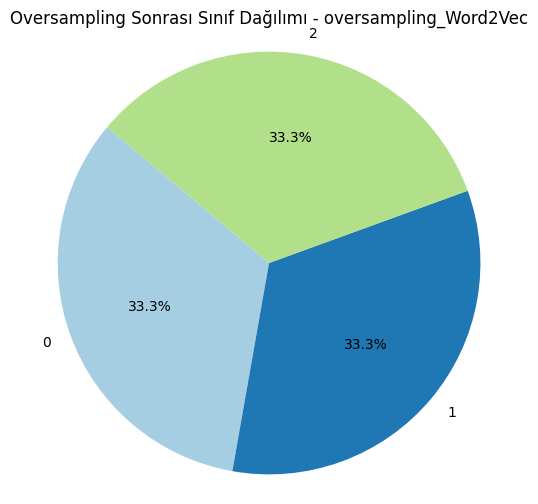

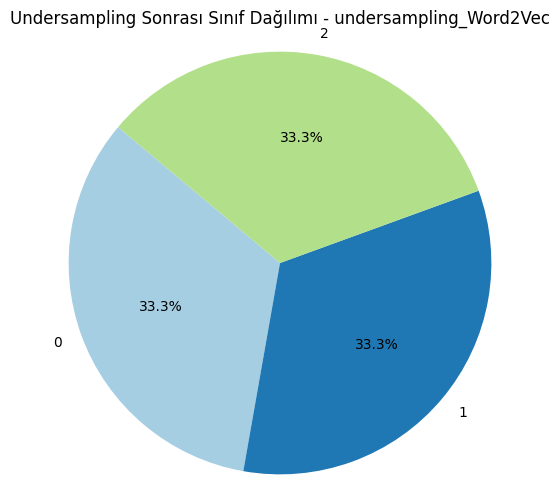

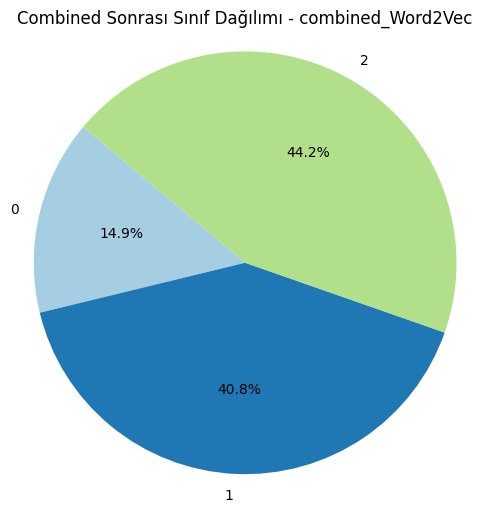

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Resampling işlemleri için kullanılacak fonksiyonlar
def resample_data(X, y, method):
    """
    Resampling işlemini gerçekleştirir (oversampling, undersampling veya combined).
    """
    if method == 'oversampling':
        resampler = SMOTE(random_state=42)
    elif method == 'undersampling':
        resampler = RandomUnderSampler(random_state=42)
    elif method == 'combined':
        resampler = SMOTEENN(random_state=42)
    else:
        raise ValueError("Geçersiz resampling yöntemi: 'oversampling', 'undersampling', veya 'combined' olmalı.")

    X_resampled, y_resampled = resampler.fit_resample(X, y)
    return X_resampled, y_resampled


# Tüm veri setleri için resampling işlemleri
resampled_data_sets = {}

# Orijinal veri
X_original = np.array(processed_data['Word Vector'].tolist())  # Giriş vektörleri
y_original = numeric_labels  # Etiketler (sınıflar)
# Oversampling sonrası
X_oversampled, y_oversampled = resample_data(X_original, y_original, method='oversampling')
resampled_data_sets[f"oversampling_{'Word2Vec'}"] = (X_oversampled, y_oversampled)

# Undersampling sonrası
X_undersampled, y_undersampled = resample_data(X_original, y_original, method='undersampling')
resampled_data_sets[f"undersampling_{'Word2Vec'}"] = (X_undersampled, y_undersampled)

# Combined yöntem sonrası
X_combined, y_combined = resample_data(X_original, y_original, method='combined')
resampled_data_sets[f"combined_{'Word2Vec'}"] = (X_combined, y_combined)

print("Seçilen kombinasyonlar için resampling işlemleri tamamlandı ve veri setleri modelde kullanılabilir hale getirildi.")

# Rastgele 1 örnek seçme ve inceleme
random_sample_key = np.random.choice(list(resampled_data_sets.keys()))
print(f"Rastgele seçilen örnek: {random_sample_key}")
X_sample, y_sample = resampled_data_sets[random_sample_key]

# Pasta grafikleri çizme fonksiyonu
def plot_pie_chart(y, title):
    labels, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Resampling yöntemlerine göre pasta grafikleri çizdirme
methods = ['oversampling', 'undersampling', 'combined']
for method in methods:
    sample_key = f"{method}_{random_sample_key.split('_', 1)[1]}"
    if sample_key in resampled_data_sets:
        _, y_resampled = resampled_data_sets[sample_key]
        plot_pie_chart(y_resampled, f"{method.capitalize()} Sonrası Sınıf Dağılımı - {sample_key}")


In [63]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Daha önce oluşturulan kombinasyonlar (count_combination_data, tfidf_combination_data) kullanılacak
# Çıktılar için dosya yolunu ayarlama
output_dir = "/content/outputs1_resample"
os.makedirs(output_dir, exist_ok=True)

# Etiketleri Yükleme ve Sayısal Dönüşüm
labels = processed_data['Etiket']
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
print(f"Etiketler dönüştürüldü: {list(label_encoder.classes_)}")

# Veri Seti Bölme Fonksiyonu

def split_data(matrix, labels):
    # LightGBM ve diğer modeller için gerekli dönüşüm
    matrix = matrix.astype(np.float32) if hasattr(matrix, 'astype') else matrix
    return train_test_split(matrix, labels, test_size=0.2, random_state=42)

# Performans Ölçüm Fonksiyonu
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Precision, Recall, F1-Score ve Accuracy hesaplamaları
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, predictions)

    # Metriği ekrana yazdırma
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    return precision, recall, f1, accuracy, predictions

# Confusion Matrix Görselleştirme Fonksiyonu
def save_confusion_matrix(y_true, y_pred, model_name, data_type, combination):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {model_name} ({data_type} - {combination})")
    file_path = os.path.join(output_dir, f"confusion_matrix_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()
    print(f"Confusion matrix kaydedildi: {file_path}")

# Eğitim ve Doğrulama Metriklerini Kaydetme Fonksiyonu
def save_training_validation_metrics(history, model_name, data_type, combination):
    epochs = range(1, len(history['loss']) + 1)

    # Loss Grafiği
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f"Loss - {model_name} ({data_type} - {combination})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    file_path_loss = os.path.join(output_dir, f"loss_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path_loss, bbox_inches='tight')
    plt.close()
    print(f"Loss grafiği kaydedildi: {file_path_loss}")

    # Accuracy Grafiği
    plt.plot(epochs, history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {model_name} ({data_type} - {combination})")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    file_path_acc = os.path.join(output_dir, f"accuracy_{model_name}_{data_type}_{combination}.png")
    plt.savefig(file_path_acc, bbox_inches='tight')
    plt.close()
    print(f"Accuracy grafiği kaydedildi: {file_path_acc}")

# Kombinasyonlar için Performans Değerlendirme Tablosu
results = []

Etiketler dönüştürüldü: ['hiçbiri', 'nefret', 'saldırgan']


In [45]:
print(resampled_data_sets.keys())


dict_keys(['oversampling_Word2Vec', 'undersampling_Word2Vec', 'combined_Word2Vec'])


In [90]:

# Random Forest Modeli

def evaluate_random_forest_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        if key != 'combined_Word2Vec':
          continue
        print(f"Random Forest ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
        n_range = range(100,200,100)
        accuracies = []
        for n in n_range:
          model = RandomForestClassifier(
              random_state=42,
              n_estimators=400,
              max_depth=10,
              min_samples_split=8

          )
          precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
          accuracies.append(accuracy)
          results.append({
              'Model': 'Random Forest',
              'Data Type': 'Resampled',
              'Kombinasyon': key,
              'Precision': precision,
              'Recall': recall,
              'F1-Score': f1,
              'Accuracy': accuracy
          })

        # Confusion Matrix Kaydetme
        save_confusion_matrix(y_test, predictions, "RandomForest", "Resampled", key)



In [91]:
# Değerlendirme İşlemi
print("Random Forest Modeli Değerlendiriliyor...")
evaluate_random_forest_resampled()

Random Forest Modeli Değerlendiriliyor...
Random Forest ile combined_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.9133, Recall: 0.9114, F1-Score: 0.9085, Accuracy: 0.9114
Confusion matrix kaydedildi: /content/outputs1_resample/confusion_matrix_RandomForest_Resampled_combined_Word2Vec.png


In [78]:

# XGBoost Modeli

def evaluate_xgboost_resampled():
    for key, (X_resampled, y_resampled) in resampled_data_sets.items():
        if key != 'combined_Word2Vec':
          continue
        print(f"XGBoost ile {key} kombinasyonu değerlendiriliyor...")
        X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled)
        n_range = range(1,2,1)
        accuracies = []
        for n in n_range:
          model = XGBClassifier(
              eval_metric='logloss',
              random_state=42,
              n_estimators=800,
              max_depth=14,
              learning_rate=0.25,
              subsample=0.7
          )

          precision, recall, f1, accuracy, predictions = evaluate_model(model, X_train, X_test, y_train, y_test)
          accuracies.append(accuracy)
          results.append({
              'Model': 'XGBoost',
              'Data Type': 'Resampled',
              'Kombinasyon': key,
              'Precision': precision,
              'Recall': recall,
              'F1-Score': f1,
              'Accuracy': accuracy
          })
          print(f"Ağaç Sayısı: {n}, Accuracy: {accuracy:.4f}")
          # Confusion Matrix Kaydetme
          save_confusion_matrix(y_test, predictions, "XGBoost", "Resampled", key)
          # Modeli kaydetme
          model_path = "xgboost_combined_word2vec.pkl"
          joblib.dump(model, model_path)
          print(f"Model '{model_path}' dosyasına kaydedildi.")



In [80]:
print("xgboost Modeli Değerlendiriliyor...")
evaluate_xgboost_resampled()




xgboost Modeli Değerlendiriliyor...
XGBoost ile combined_Word2Vec kombinasyonu değerlendiriliyor...
Precision: 0.9769, Recall: 0.9771, F1-Score: 0.9768, Accuracy: 0.9771
Ağaç Sayısı: 1, Accuracy: 0.9771
Confusion matrix kaydedildi: /content/outputs1_resample/confusion_matrix_XGBoost_Resampled_combined_Word2Vec.png
Model 'xgboost_combined_word2vec.pkl' dosyasına kaydedildi.
